# Neural network model to predict DIC
Created by Ivan Lima on Mon Jan 23 2023 22:12:53 -0500

**This version of the neural network model does not include dissolved oxygen as an input feature.**

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, datetime, warnings
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Sun Feb  5 13:22:09 2023


In [2]:
import sns_settings
sns.set_context('paper')
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')

## Load DIC bottle data

In [3]:
df_bottle_dic = pd.read_csv('data/bottle_data_DIC_prepared.csv', parse_dates=['Date'],
                            index_col=0, na_values=['<undefined>',-9999.])
df_bottle_dic['log_Chl'] = np.log(df_bottle_dic.Chl)
df_bottle_dic['log_KD490'] = np.log(df_bottle_dic.KD490)

## Select input features and target variable

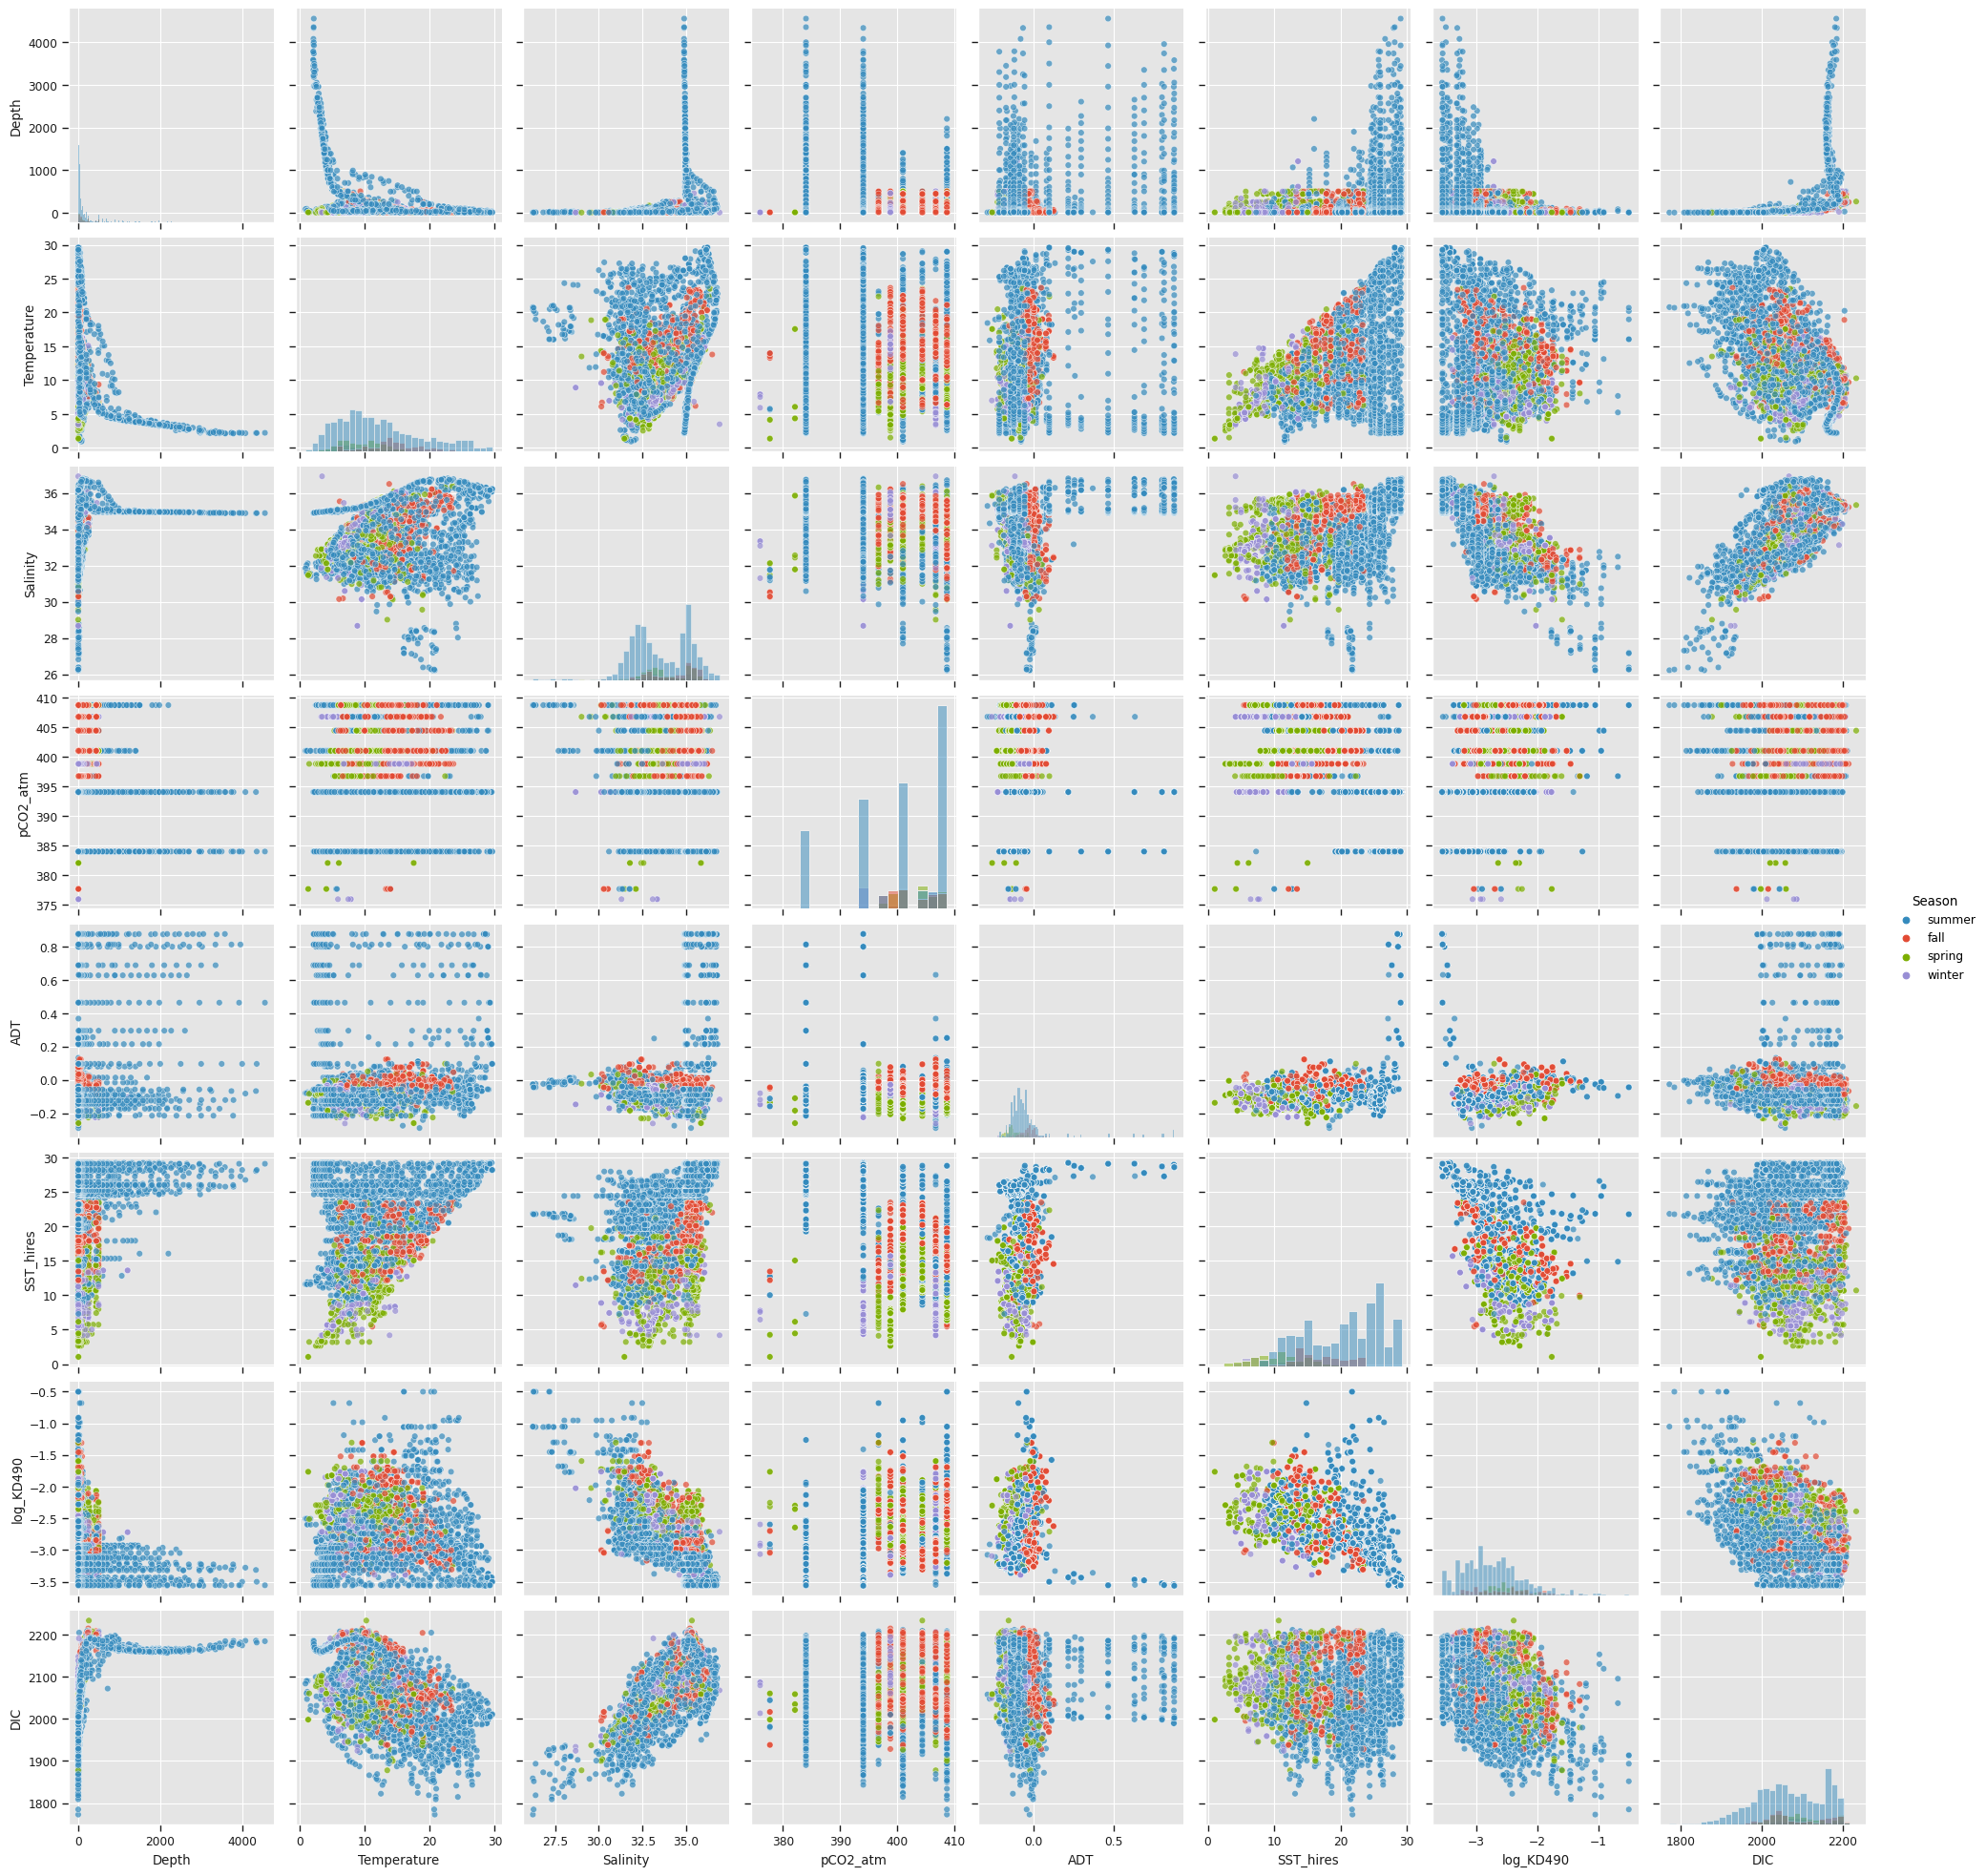

In [4]:
features = ['Depth', 'Temperature', 'Salinity', 'pCO2_atm', 'ADT', 'SST_hires', 'log_KD490']
target = ['DIC']
varlist = features + target
fg = sns.pairplot(df_bottle_dic, vars=varlist, hue='Season', plot_kws={'alpha':0.7}, diag_kind='hist')

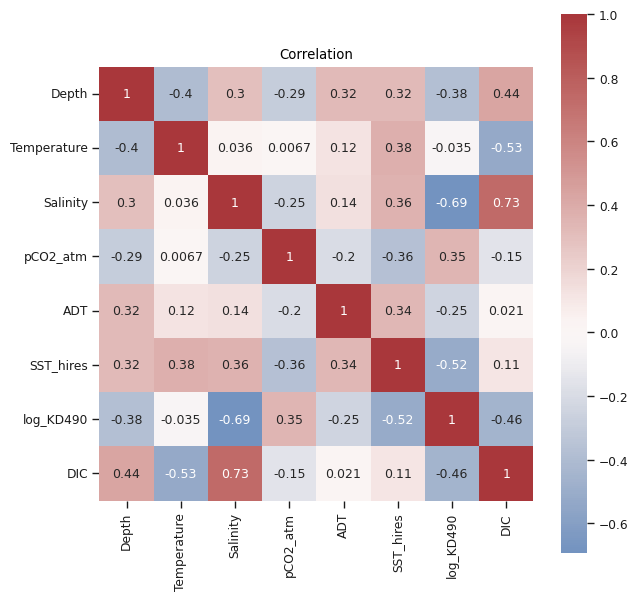

In [5]:
data = df_bottle_dic[varlist]
corr_mat = data.corr()
fig, ax = plt.subplots(figsize=(7,7))
_ = sns.heatmap(corr_mat, ax=ax, cmap='vlag', center=0, square=True, annot=True, annot_kws={'fontsize':9})
_ = ax.set_title('Correlation')

## Split data into training and test sets 

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score

data = df_bottle_dic[features + target + ['Season']].dropna()

X = data[features].values
y = data[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=data.Season.values, random_state=77)
X.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4350, 7), (3262, 7), (1088, 7), (3262, 1), (1088, 1))

## Train Neural Network regression 

In [7]:
import tensorflow as tf
from tensorflow import keras

keras.utils.set_random_seed(42) # make things reproducible
n_hidden = 256 # number of nodes in hidden layers
alpha=0.01

model = keras.models.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_hidden, input_shape=X_train.shape[1:]),
    keras.layers.LeakyReLU(alpha=alpha),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_hidden),
    keras.layers.LeakyReLU(alpha=alpha),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(y_train.shape[1])
])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam())
history = model.fit(X_train, y_train, epochs=700, verbose=2, validation_split=0.2, callbacks=[early_stopping_cb])

Epoch 1/700


2023-02-05 13:23:00.252410: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


82/82 - 1s - loss: 4295560.5000 - val_loss: 4132539.7500 - 1s/epoch - 15ms/step
Epoch 2/700
82/82 - 0s - loss: 4261573.0000 - val_loss: 4032585.2500 - 227ms/epoch - 3ms/step
Epoch 3/700
82/82 - 0s - loss: 4195029.5000 - val_loss: 3983974.0000 - 234ms/epoch - 3ms/step
Epoch 4/700
82/82 - 0s - loss: 4091591.2500 - val_loss: 3899459.0000 - 228ms/epoch - 3ms/step
Epoch 5/700
82/82 - 0s - loss: 3953473.2500 - val_loss: 3790599.0000 - 218ms/epoch - 3ms/step
Epoch 6/700
82/82 - 0s - loss: 3784571.0000 - val_loss: 3638522.5000 - 212ms/epoch - 3ms/step
Epoch 7/700
82/82 - 0s - loss: 3589534.0000 - val_loss: 3446617.5000 - 213ms/epoch - 3ms/step
Epoch 8/700
82/82 - 0s - loss: 3372989.2500 - val_loss: 3237511.5000 - 218ms/epoch - 3ms/step
Epoch 9/700
82/82 - 0s - loss: 3139982.7500 - val_loss: 3006159.5000 - 213ms/epoch - 3ms/step
Epoch 10/700
82/82 - 0s - loss: 2895169.7500 - val_loss: 2762621.2500 - 213ms/epoch - 3ms/step
Epoch 11/700
82/82 - 0s - loss: 2643437.0000 - val_loss: 2503281.7500 - 2

### Save trained model

In [8]:
model.save('models/nn_regression_dic_noO2.h5')

### Learning curve

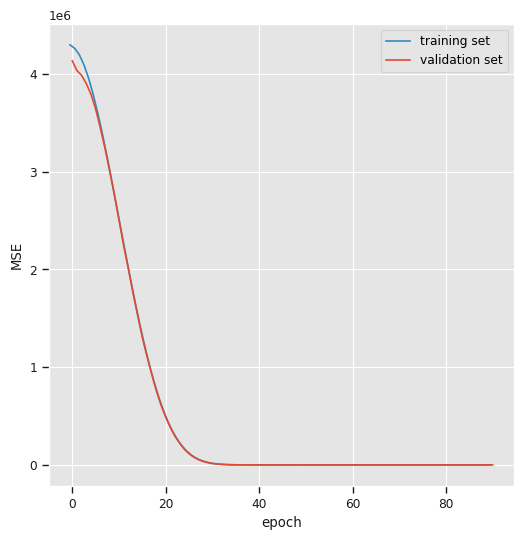

In [9]:
df_history = pd.DataFrame(history.history)
df_history.index.name = 'epoch'
df_history = df_history.reset_index()
df_history.to_csv('results/nn_regression_history_dic_noO2.csv')

fig, ax = plt.subplots(figsize=(6, 6))
_ = sns.lineplot(x=df_history.epoch-0.5, y='loss', data=df_history, ax=ax, label='training set')
_ = sns.lineplot(x=df_history.epoch, y='val_loss', data=df_history, ax=ax, label='validation set')
_ = ax.set(ylabel = 'MSE')
# _ = ax.set(yscale='log')

### MSE & $R^2$

In [10]:
from sklearn.metrics import r2_score

print('MSE on training set = {:.2f}'.format(model.evaluate(X_train, y_train, verbose=0)))
print('MSE on test set     = {:.2f}\n'.format(model.evaluate(X_test, y_test, verbose=0)))

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print('R squared on training set = {:.3f}'.format(r2_score(y_train, y_pred_train)))
print('R squared on test set     = {:.3f}'.format(r2_score(y_test, y_pred_test)))

MSE on training set = 308.82
MSE on test set     = 365.76

R squared on training set = 0.952
R squared on test set     = 0.944


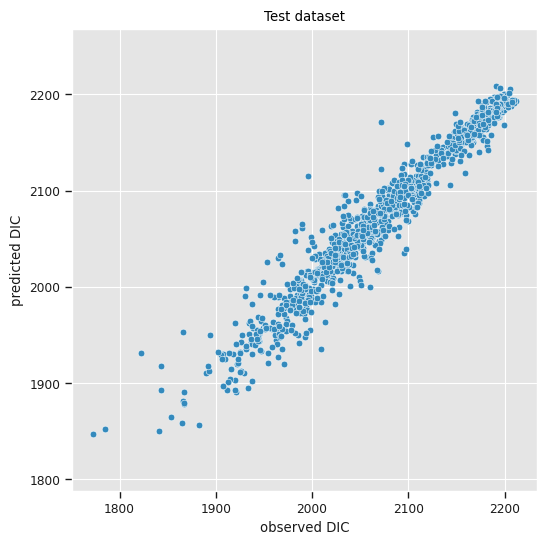

In [11]:
fig, ax = plt.subplots(figsize=(6,6))
_ = sns.scatterplot(x=y_test.ravel(), y=y_pred_test.ravel(), ax=ax)
_ = ax.set(xlabel='observed DIC', ylabel='predicted DIC', title='Test dataset')
_ = ax.axis('equal')

In [12]:
# save test set features, target & predictions
df_test = pd.DataFrame(np.c_[X_test, y_test, y_pred_test], columns = features + ['DIC observed', 'DIC predicted'])
df_test['DIC residuals'] = df_test['DIC observed'] - df_test['DIC predicted']
df_test.to_csv('results/bottle_data_test_dic_noO2.csv')

## K-fold cross-validation

In [13]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
score_vals = [] # store score values

nn_reg = keras.models.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_hidden, input_shape=X_train.shape[1:]),
    keras.layers.LeakyReLU(alpha=alpha),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_hidden),
    keras.layers.LeakyReLU(alpha=alpha),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(y_train.shape[1])
])
nn_reg.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam())

for k, (train_idx, test_idx) in enumerate(kf.split(X_train)):
    X_tr, X_te = X_train[train_idx], X_train[test_idx]
    y_tr, y_te = y_train[train_idx], y_train[test_idx]
    history_cv = nn_reg.fit(X_tr, y_tr, epochs=700, verbose=0, validation_split=0.2, callbacks=[early_stopping_cb])
    y_pred = nn_reg.predict(X_te)
    score = r2_score(y_te, y_pred)
    score_vals.append(score)
    print('Fold {} test set R squared: {:.3f}'.format(k+1, score))

scores = np.array(score_vals)
print('\nBest R squared:  {:.3f}'.format(scores.max()))
print('Worst R squared: {:.3f}'.format(scores.min()))
print('Mean R squared:  {:.3f}'.format(scores.mean()))

Fold 1 test set R squared: 0.933
Fold 2 test set R squared: 0.948
Fold 3 test set R squared: 0.951
Fold 4 test set R squared: 0.931
Fold 5 test set R squared: 0.950

Best R squared:  0.951
Worst R squared: 0.931
Mean R squared:  0.943
